
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic waves and water level timeseries

inputs required: 
  * Historical DWTs
  * Historical AWT and IWT
  * Synthetic timeseries of AWT and IWT
  * Historical wave families 
  * Historical intradaily hydrograph parameters
  * TCs waves
  * Historical runup at 3 locations
  
in this notebook:
  * Fit a multivariate extreme model for the waves associated to each DWT
  * Generate synthetic time series of wave conditions
  * Validate the synthetic waves by means of mean distributions



### Workflow:

<div>
<img src="resources/nb01_12.png" width="400px">
</div>



The **synthetic generation of wave conditions on a regular climate** (DWT1-36) is based on the work of Rueda et al. 2017. The probability of SW1, SW2, and SEA components being present (1) or not present (0) at the time of observed peak TWLproxy was used to create eight potential sea-states within each DWT (000, 100, 010, 001, 110, 101, 011, 111) defined by Bernoulli distributions . For each hydrograph produced in the simulations of climate, a random pick from the appropriate Bernoulli distribution determined which sea state was present during that hydrograph. A subsequent random pick from the assigned sea state’s marginal distributions defined the waves at the maximum TWL peak within the simulated hydrograph.

The marginal distributions of waves and surge levels were associated with each other using multivariate gaussian copulas. The copulas define the dependence structure, or joint probabilities, between each environmental parameter within a sea state by identifying correlation matrices after transforming each marginal distribution to a uniform distribution. Identifying the correlation across all parameters through the copulas ensures that realistic combinations of compounding environmental parameters are present in the hypothetical time series (i.e., large storm waves approach from appropriate wave directions) (Masina et al. 2015; Corbella & Stretch, 2013). The marginal distributions of wave heights were defined by GEVs to allow for simulation of extremes with longer return periods than the observation period, while wave periods and directions were defined by empirical distributions constructed from observations. 

Additional parameters including τ (timing of the peak TWL within a hydrograph) and μ (area under the hydrograph) were also added to each copula and randomly sampled for each simulated hydrograph. The two parameters effectively define a trapezoidal shape for each simulated hydrograph, analogous to the storm schematization of other recent works (e.g., Poelhekke et al., 2016). Including these parameters in the copulas accounts for correlation between storminess and hydrograph shape (peaky hydrographs are commonly associated with storm conditions while more flat hydrographs typically occur during calmer conditions). The shape of the simulated hydrograph will be use to interpolate to an hourly value of the TWLproxy, and subsequently an hourly value of wave conditions *(notebook 14)*

In the case on **waves associated to a TC event**, the associated simulated waves from WWIII simulation that have been reconstructed in *notebook 07* are use whenever the simulated TC enters the 4 degrees radio.




In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies

from teslakit.plotting.outputs import Plot_FitSim_Histograms
from teslakit.plotting.extremes import Plot_FitSim_AnnualMax, Plot_FitSim_GevFit, Plot_Fit_QQ

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_emulator')


In [7]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS = db.Load_WAVES_hist()      # Historical gow waves point
#WVS = xr.open_dataset('/Users/albacid/Downloads/waves_historical_albaR.nc')
#WVS['time'] = WVS['time'].dt.round('H')
#WVS['TC_category'] = kk.TC_category


KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation (Simulate_Waves): ESTELA DWT 

DWTs_sim = db.Load_ESTELA_DWT_sim()


# --------------------------------------
# Load data for climate emulator simulation (Simulate_TCs): TCs (MU, TAU) for N, S & E
TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 

#TCs_RBFs_N = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN_emulator/TCs/TCs_sim_r2_RBF_output_N.nc'))  # TCs numerical-RBFs_interpolation output
#TCs_RBFs_S = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN_emulator/TCs/TCs_sim_r2_RBF_output_S.nc'))  # TCs numerical-RBFs_interpolation output
TCs_RBFs_E = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN_emulator/TCs/TCs_sim_r2_RBF_output_E.nc'))  # TCs numerical-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

#l_mutau_wt_N = db.Load_MU_TAU_hydrograms(location = 'N')   # MU - TAU intradaily hidrographs for each DWT
#l_mutau_wt_S = db.Load_MU_TAU_hydrograms(location = 'S')   # MU - TAU intradaily hidrographs for each DWT
l_mutau_wt_E = db.Load_MU_TAU_hydrograms(location = 'E')   # MU - TAU intradaily hidrographs for each DWT

#MU_WT_N = np.array([x.MU.values[:] for x in l_mutau_wt_N])  # MU and TAU numpy arrays
#TAU_WT_N = np.array([x.TAU.values[:] for x in l_mutau_wt_N])
#MU_WT_S = np.array([x.MU.values[:] for x in l_mutau_wt_S])  # MU and TAU numpy arrays
#TAU_WT_S = np.array([x.TAU.values[:] for x in l_mutau_wt_S])
MU_WT_E = np.array([x.MU.values[:] for x in l_mutau_wt_E])  # MU and TAU numpy arrays
TAU_WT_E = np.array([x.TAU.values[:] for x in l_mutau_wt_E])


NameError: name 'TCs_RBFs_' is not defined

In [8]:

print(TCs_RBFs_E)
sys.exit()

<xarray.Dataset>
Dimensions:  (storm: 10159)
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 ... 10153 10154 10155 10156 10157 10158
Data variables:
    hs       (storm) float64 ...
    tp       (storm) float64 ...
    dir      (storm) float64 ...
    ss       (storm) float64 ...
    twl      (storm) float64 ...
    mu       (storm) float64 ...
    tau      (storm) float64 ...
Attributes:
    source:   teslakit_v0.9.1


SystemExit: 

In [4]:
# --------------------------------------
# Load runup as proxy variable for max. storms

runup_N = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/hist_runup_N.nc')
runup_S = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/hist_runup_S.nc')
runup_E = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/hist_runup_E.nc')

runup_N = runup_N.drop({'level','hs_lo2','rslope','bslope','rwidth', 'cf','hs','tp','dir'})
runup_S = runup_S.drop({'level','hs_lo2','rslope','bslope','rwidth', 'cf','hs','tp','dir'})
runup_E = runup_E.drop({'level','hs_lo2','rslope','bslope','rwidth', 'cf','hs','tp','dir'})

runup_N = runup_N.rename({'runup':'runup_N'})
runup_S = runup_S.rename({'runup':'runup_S'})
runup_E = runup_E.rename({'runup':'runup_E'})

runup = xr.merge([runup_N, runup_S, runup_E])


# WORST runup from the 3 profiles    
runup['runup_max'] = (('time'),np.nanmax(np.vstack((runup.runup_N.values, runup.runup_S.values, runup.runup_E.values)), axis=0))
print(runup)
print()


# --------------------------------------
# Load SLP and Wind to include in the emulator

# SLP
press = db.Load_ESTELA_SLP()                

# Kwajalein: pnt_lon = 167.73, pnt_lat = 8.66
lonp = 168 # closest coordinates in SLP dataset
latp = 8

# select closest grid point to Site
press = press.sel(longitude = lonp, latitude = latp) 


# WIND
wind = pd.read_pickle('/Users/albacid/Projects/SERDP/inputs_Kwajalein/wind.pkl')
wind = wind.to_xarray()

print(press)
print()
print(wind)


<xarray.Dataset>
Dimensions:    (time: 359401)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2020-01-01
Data variables:
    runup_N    (time) float64 0.8017 0.7133 0.6826 ... 0.7547 0.8026 0.8478
    runup_S    (time) float64 0.0 0.4745 0.6168 0.7801 ... 1.738 2.594 2.601
    runup_E    (time) float64 0.0 0.5804 0.8814 1.114 ... 1.855 2.357 2.368
    runup_max  (time) float64 0.8017 0.7133 0.8814 1.114 ... 1.855 2.594 2.601

<xarray.Dataset>
Dimensions:    (time: 359401)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 2020-01-01
    longitude  float32 168.0
    latitude   float32 8.0
Data variables:
    SLP        (time) float64 ...

<xarray.Dataset>
Dimensions:  (time: 362304)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2020-04-30T23:00:00
Data variables:
    w        (time) float64 11.69 11.64 11.58 11.58 ... 10.51 10.13 10.44 10.68
    wdir     (time) float64 54.62 59.44 61.1 61.5 ... 64.94 65.98 60.83 59.95


In [5]:
# solve first 10 DWTs simulations

DWTs_sim = DWTs_sim.isel(n_sim=slice(0, 10))

print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 365244)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 3000-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 ...
Attributes:
    source:   teslakit_v0.9.1



## Climate Emulator - Fitting

In [6]:
# Waves and KMA bmus data share time limits
WVS_fit = WVS.sel(time = slice(DWTs_fit.time[0], DWTs_fit.time[-1]))

runup = runup.sel(time=slice(DWTs_fit.time[0], DWTs_fit.time[-1]))

press = press.sel(time=slice(DWTs_fit.time[0], DWTs_fit.time[-1]))
wind = wind.sel(time=slice(DWTs_fit.time[0], DWTs_fit.time[-1]))


# add extra data to WAVES dataset

#WVS_fit['AWL'] = AWL(WVS_fit['Hs'], WVS_fit['Tp']) # Waves AWL proxy variable for max. storms
WVS_fit['runup'] = (('time'), runup.runup_max) # Waves runup proxy variable for max. storms
WVS_fit['wind_speed'] = (('time'), wind.w)
WVS_fit['wind_dir'] = (('time'), wind.wdir)
WVS_fit['mslp'] = (('time'), press.SLP)

print(WVS_fit)

In [7]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Fit extremes model
config = {
    'waves_families': ['sea', 'swell_1', 'swell_2'],
    'extra_variables': ['wind_speed', 'wind_dir', 'mslp'],
    'distribution': [
        ('sea_Tp', 'Empirical'),
        ('wind_dir', 'Empirical'),
        ('mslp', 'Empirical'),
        ('wind_speed', 'Weibull'),
    ],
    'do_chromosomes': False,
}


#CE.FitExtremes(DWTs_fit, WVS_fit, config, proxy='runup')

# Load Climate Emulator (only need to Fit CE once)
CE.Load()



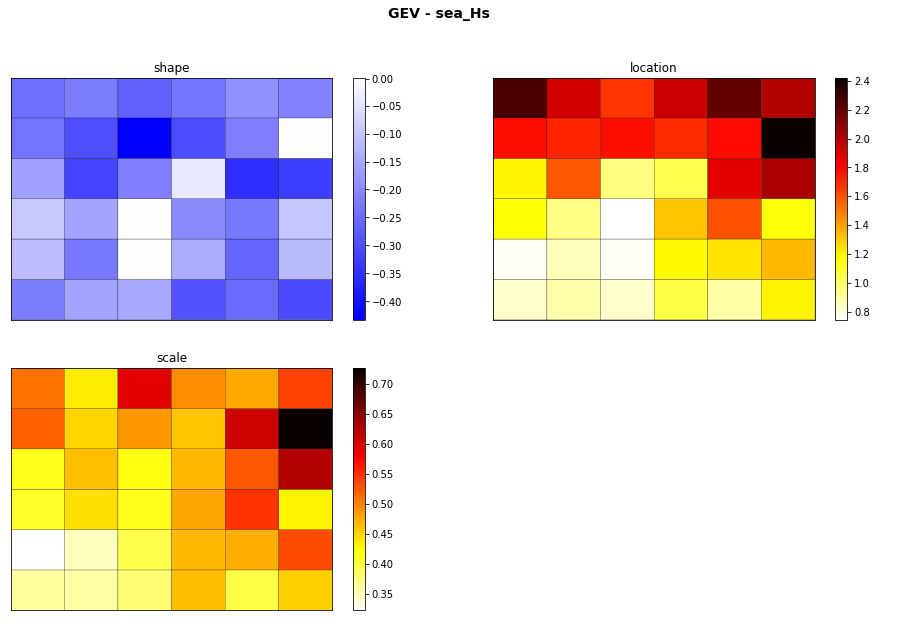

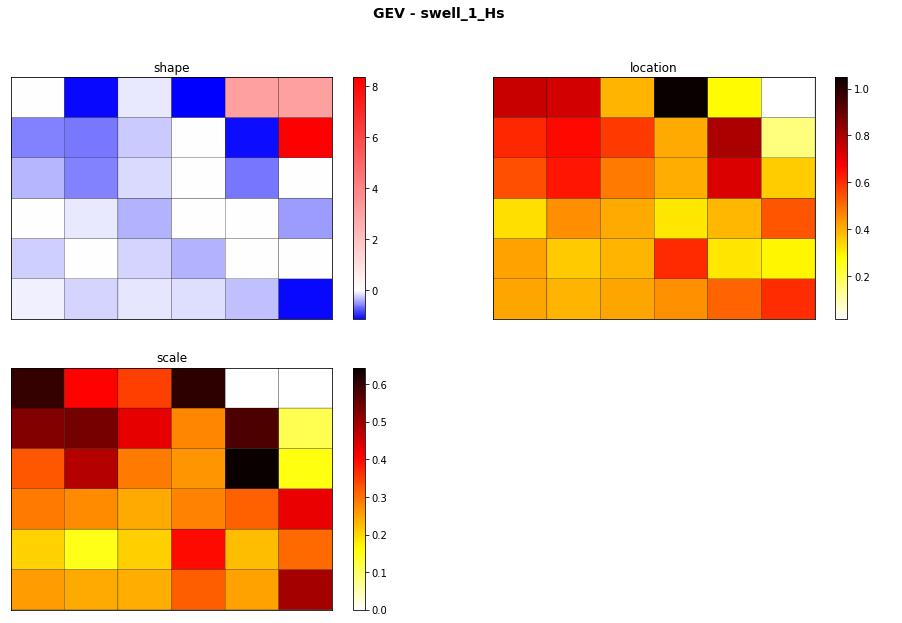

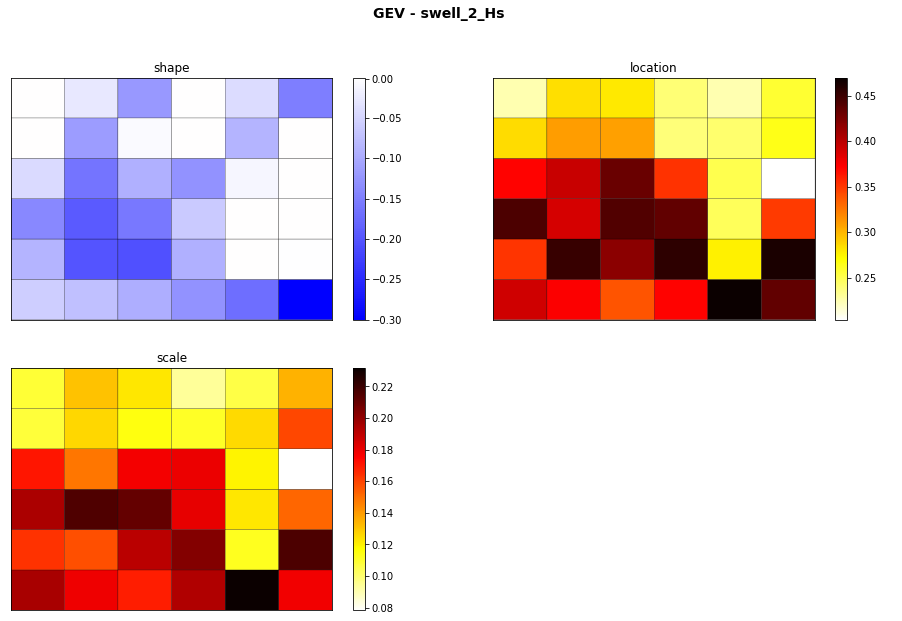

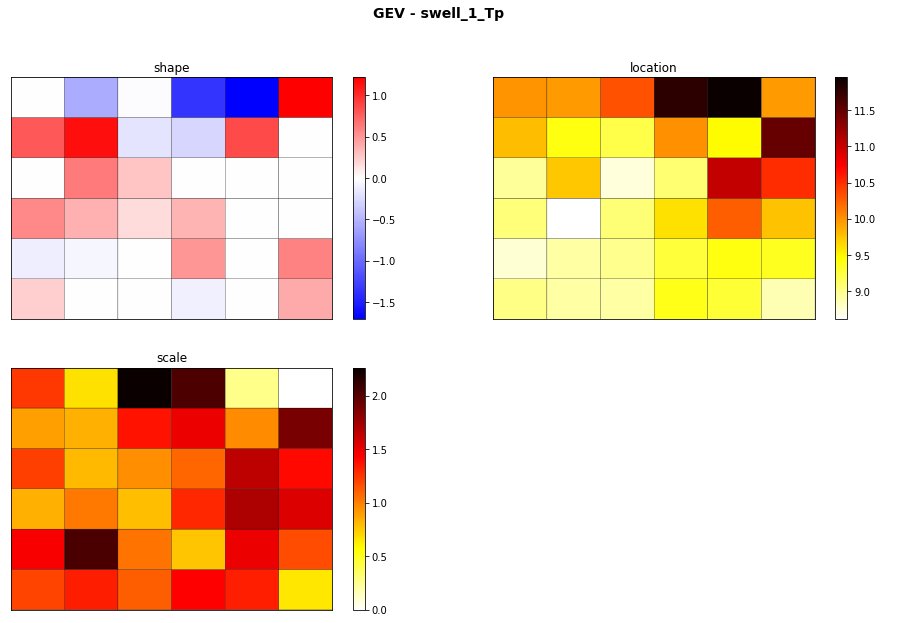

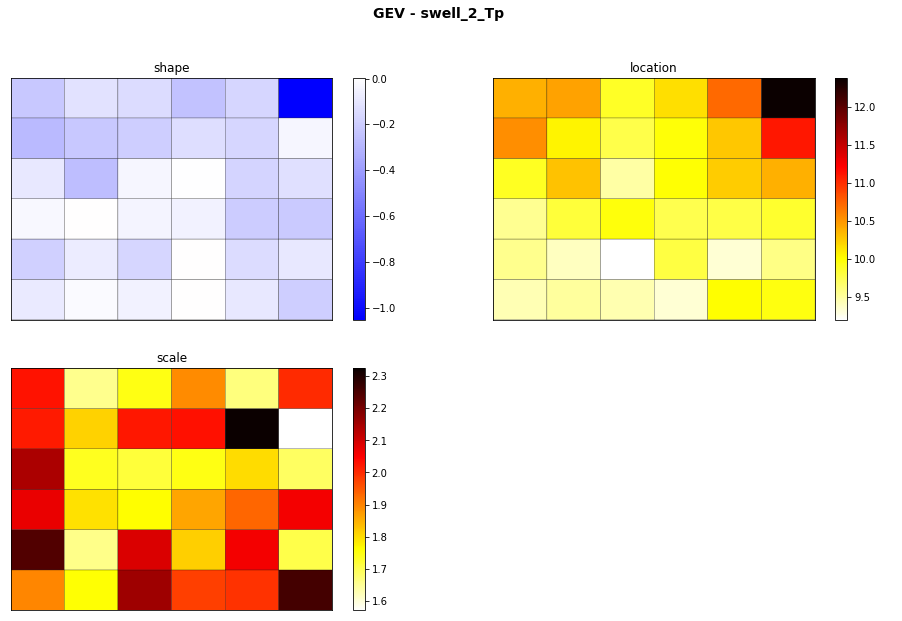

In [8]:
# Fit report figures

CE.Report_Fit(vns_GEV=['Hs', 'Tp'], plot_chrom=False, plot_sigma=False);



## Climate Emulator - Simulation

In [9]:
 # optional: list variables to override distribution to empirical
CE.sim_icdf_empirical_override = ['sea_Hs_31',
                                  'swell_1_Hs_1','swell_1_Tp_1',
                                  'swell_1_Hs_2','swell_1_Tp_2',
                                  'swell_1_Hs_7','swell_1_Tp_7', 
                                  'swell_1_Hs_13','swell_1_Tp_13', 
                                  'swell_1_Hs_19','swell_1_Tp_19',
                                  'swell_1_Hs_25','swell_1_Tp_25',
                                  'swell_1_Hs_26','swell_1_Tp_26',
                                  'swell_1_Hs_31','swell_1_Tp_31',
                                  'swell_1_Hs_32','swell_1_Tp_32',
                                  'swell_1_Hs_33','swell_1_Tp_33',
                                  'swell_1_Hs_36','swell_1_Tp_36',
                                  'swell_2_Hs_31','swell_2_Tp_31']

# set simulated waves min-max filter
CE.sim_waves_filter.update({
    'hs': (0, 8),
    'tp': (2, 25),
#    'ws': (0, 0.06),
})


In [12]:
#DWTs_sim = DWTs_sim.isel(time=slice(0,365*100+25), n_sim=slice(0,1))
#DWTs_sim = DWTs_sim.isel(time=slice(0,365*10), n_sim=slice(0,1))
DWTs_sim = DWTs_sim.isel(time=slice(0,365*100+25))
print(DWTs_sim)

<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 36525)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 2099-12-31 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 ...
Attributes:
    source:   teslakit_v0.9.1


In [13]:
# --------------------------------------
#  Climate Emulator simulation

# each DWT series will generate a different set of waves
for n in DWTs_sim.n_sim:
    print('- Sim: {0} -'.format(int(n)+1))
    
    # Select DWTs simulation
    DWTs = DWTs_sim.sel(n_sim=n)

    # Simulate waves
    n_ce = 1  # (one CE sim. for each DWT sim.)
    WVS_sim = CE.Simulate_Waves(DWTs, n_ce, filters={'hs':True, 'tp':True, 'ws':True})
#    WVS_sim, _, _ = CE.LoadSim(n_sim = 0)


    # Simulate TCs and update simulated waves
    TCs_sim_E, WVS_upd_E = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs_E, pchange_TCs, MU_WT_E, TAU_WT_E)
    #TCs_sim_N, WVS_upd_N = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs_N, pchange_TCs, MU_WT_N, TAU_WT_N)
    #TCs_sim_S, WVS_upd_S = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs_S, pchange_TCs, MU_WT_S, TAU_WT_S)
    
    # store simulation data
    CE.SaveSim(WVS_sim, TCs_sim_E, WVS_upd_E, int(n))
    
    

- Sim: 1 -


C.E: Sim. TCs  : 100%|██████████| 10141/10141 [00:00<00:00, 23193.15it/s]


- Sim: 2 -


C.E: Sim. TCs  : 100%|██████████| 10434/10434 [00:00<00:00, 24100.84it/s]


- Sim: 3 -


C.E: Sim. TCs  : 100%|██████████| 10397/10397 [00:00<00:00, 23812.91it/s]


- Sim: 4 -


C.E: Sim. TCs  : 100%|██████████| 10175/10175 [00:00<00:00, 23671.44it/s]


- Sim: 5 -


C.E: Sim. TCs  : 100%|██████████| 10257/10257 [00:00<00:00, 24095.96it/s]


- Sim: 6 -


C.E: Sim. TCs  : 100%|██████████| 10508/10508 [00:00<00:00, 23835.13it/s]


- Sim: 7 -


C.E: Sim. TCs  : 100%|██████████| 10289/10289 [00:00<00:00, 22354.22it/s]


- Sim: 8 -


C.E: Sim. TCs  : 100%|██████████| 10167/10167 [00:00<00:00, 22666.26it/s]


- Sim: 9 -


C.E: Sim. TCs  : 100%|██████████| 10176/10176 [00:00<00:00, 23474.32it/s]


- Sim: 10 -


C.E: Sim. TCs  : 100%|██████████| 10445/10445 [00:00<00:00, 23452.46it/s]


<xarray.Dataset>
Dimensions:      (n_sim: 1, time: 10445)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2099-12-31
Dimensions without coordinates: n_sim
Data variables:
    DWT          (n_sim, time) float32 ...
    sea_Hs       (n_sim, time) float32 ...
    sea_Tp       (n_sim, time) float32 ...
    sea_Dir      (n_sim, time) float32 ...
    swell_1_Hs   (n_sim, time) float32 ...
    swell_1_Tp   (n_sim, time) float32 ...
    swell_1_Dir  (n_sim, time) float32 ...
    swell_2_Hs   (n_sim, time) float32 ...
    swell_2_Tp   (n_sim, time) float32 ...
    swell_2_Dir  (n_sim, time) float32 ...
    wind_speed   (n_sim, time) float32 ...
    wind_dir     (n_sim, time) float32 ...
    mslp         (n_sim, time) float32 ...

<xarray.Dataset>
Dimensions:  (n_sim: 1, time: 10445)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2099-12-31
Dimensions without coordinates: n_sim
Data variables:
    mu       (n_sim, time) float32 ...
    tau

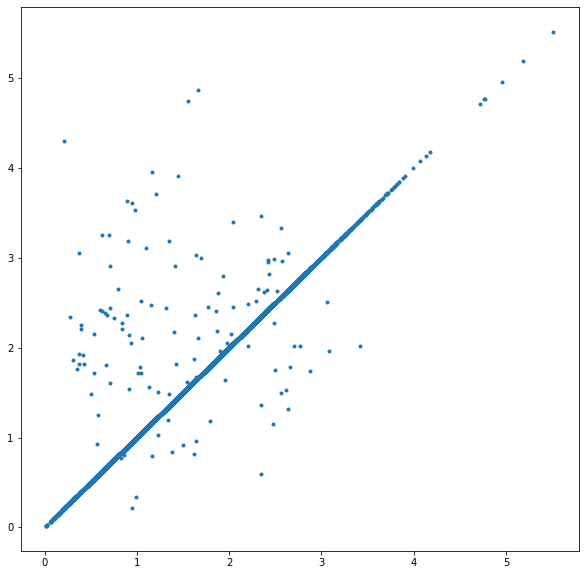

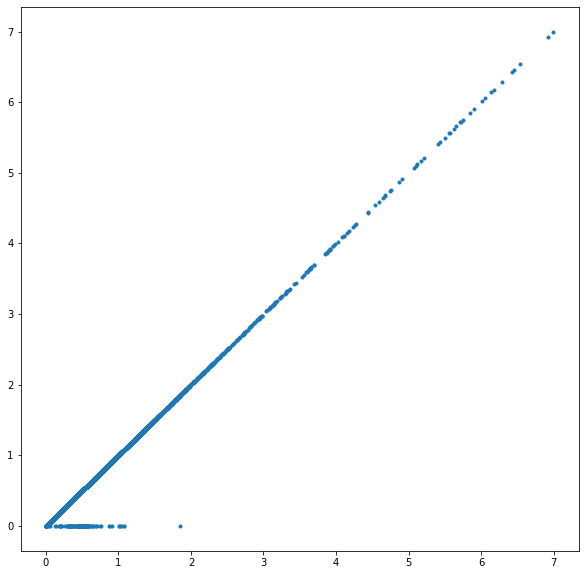

In [16]:
WVS_sim = xr.open_dataset('/Users/albacid/Desktop/WVS_sim.nc')

TCs_sim_E = xr.open_dataset('/Users/albacid/Desktop/TCs_sim_E.nc')
WVS_upd_E = xr.open_dataset('/Users/albacid/Desktop/WVS_upd_E.nc')

print(WVS_sim)
print()
print(TCs_sim_E)
print()
print(WVS_upd_E)

plt.figure(figsize=(10,10))
plt.plot(WVS_sim.sea_Hs.isel(n_sim=0), WVS_upd_E.sea_Hs.isel(n_sim=0), '.')

plt.figure(figsize=(10,10))
plt.plot(WVS_sim.swell_1_Hs.isel(n_sim=0), WVS_upd_E.swell_1_Hs.isel(n_sim=0), '.')

In [22]:
# Poner NaN en WVS_upd_E donde Hs, Tp y Dir de Swell_1 y Swell_2 valen 0 (Hubo TC y sólo tenemos Sea family)
vars = {'swell_1_Hs','swell_1_Tp','swell_1_Dir','swell_2_Hs','swell_2_Tp','swell_2_Dir'}
for var in vars:
    WVS_upd_E[var] = WVS_upd_E[var].where(WVS_upd_E[var]!=0.0, np.nan)

    
# Unir las wind y mslp de WVS_sim a WVS_upd_E
WVS_sim_extravars = WVS_sim.copy(deep=True)
WVS_sim_extravars = WVS_sim_extravars.drop({'DWT','sea_Hs','sea_Tp','sea_Dir',
                                            'swell_1_Hs','swell_1_Tp','swell_1_Dir','swell_2_Hs','swell_2_Tp','swell_2_Dir'})

WVS_upd = xr.merge([WVS_upd_E,WVS_sim_extravars])

print(WVS_upd)


<xarray.Dataset>
Dimensions:      (n_sim: 1, time: 10445)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2099-12-31
Dimensions without coordinates: n_sim
Data variables:
    DWT          (n_sim, time) float32 ...
    sea_Hs       (n_sim, time) float32 ...
    sea_Tp       (n_sim, time) float32 ...
    sea_Dir      (n_sim, time) float32 ...
    swell_1_Hs   (n_sim, time) float32 2.915211 0.7178429 ... 0.8718332
    swell_1_Tp   (n_sim, time) float32 9.704451 11.207441 ... 4.1375594 8.078175
    swell_1_Dir  (n_sim, time) float32 68.8707 80.14397 ... 88.13062 89.40776
    swell_2_Hs   (n_sim, time) float32 0.42948243 0.38080156 ... 0.1871284
    swell_2_Tp   (n_sim, time) float32 10.5012665 9.632617 ... 12.450415
    swell_2_Dir  (n_sim, time) float32 165.94945 159.2316 ... 174.09686
    wind_speed   (n_sim, time) float32 5.0254126 3.1882114 ... 8.222698
    wind_dir     (n_sim, time) float32 66.59093 56.88333 ... 64.46226 53.173244
    mslp         (n_sim,


## Climate Emulator Simulation Validation

In [ ]:
# --------------------------------------
# Select Simulation to plot

# 2 levels of simulation now:
n_sim_DWTs = 0  # switch DWTs Simulation (used at CE Sim.)
n_sim_CE = 0    # switch WAVES Simulation (generated from CE Sim.)

# Load Waves simulated for DWTs set number "n_sim_DWTs"
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim(n_sim = n_sim_DWTs)

# only one climate emulator simulation
WVS_sim = WVS_sim.isel(n_sim = n_sim_CE)
TCs_sim = TCs_sim.isel(n_sim = n_sim_CE)
WVS_upd = WVS_upd.isel(n_sim = n_sim_CE)


# select data
WVS_fit_p = CE.WVS_MS
WVS_sim_p = WVS_upd  # with simulated TCs



## Climate Emulator Validation: Waves Families Variables

In [ ]:
# Plot simulated waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_fit_p, WVS_sim_p);


In [ ]:
# Plot simulated extra variables (if any)
print(WVS_fit_p)
print(WVS_sim_p)
sys.exit()
extra_vars = ['wind_speed', 'wind_dir', 'mslp']  # example
Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, extra_vars, density=True,
    color_1='white', color_2='palevioletred',
);



## Climate Emulator Validation: Hs families

In [ ]:
# waves families Hs
vvs = ['sea_Hs', 'swell_1_Hs', 'swell_2_Hs']

# histograms comparison
Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
);


In [ ]:
# plot selection
vns_lims = {
    'sea_Hs':(2, 30),
    'swell_1_Hs':(2, 30),
    'swell_2_Hs':(3, 30),

}

Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
    vns_lims=vns_lims,
);


In [ ]:
# annual maxima comparison
Plot_FitSim_AnnualMax(
    WVS_fit_p, WVS_sim_p, vvs,
    color_1='mediumvioletred', color_2='indigo',
);


In [ ]:
# GEV fit - sim comparison and QQ plot

Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'sea_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=1.5,
);

Plot_Fit_QQ(
    WVS_fit_p, 'sea_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);


# TODO
#CE.Report_Sim_GevFit(WVS_sim_p, 'swell_1_Hs') ?


In [ ]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_1_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=4,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_1_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);


In [ ]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_2_Hs', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=4,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_2_Hs', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);



## Climate Emulator Validation: Tp families

In [ ]:
# waves families Tp
vvs = ['sea_Tp', 'swell_1_Tp', 'swell_2_Tp']

# histograms comparison
Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
);


In [ ]:
# plot selection
vns_lims = {
    'sea_Tp':(14, 30),
    'swell_1_Tp':(16, 30),
    'swell_2_Tp':(11, 30),

}

Plot_FitSim_Histograms(
    WVS_fit_p, WVS_sim_p, vvs, density=True,
    color_1='indigo', color_2='palevioletred',
    vns_lims=vns_lims,
);


In [ ]:
# annual maxima comparison
Plot_FitSim_AnnualMax(
    WVS_fit_p, WVS_sim_p, vvs,
    color_1='mediumvioletred', color_2='indigo',
);


In [ ]:
# GEV fit comparison
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_1_Tp', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_1_Tp', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);


In [ ]:
Plot_FitSim_GevFit(
    WVS_fit_p, WVS_sim_p, 'swell_2_Tp', CE.GEV_Par, CE.KMA_MS,
    alpha_1=0.7, alpha_2=0.5, n_bins=30,
    color_1='indigo', color_2='plum',
    gs_1 = 6, gs_2 = 6, n_clusters = 36, vlim=20,
);

Plot_Fit_QQ(
    WVS_fit_p, 'swell_2_Tp', CE.GEV_Par, CE.KMA_MS,
    gs_1 = 6, gs_2 = 6, n_clusters = 36,
);


## Climate Emulator Validation: Aggregated Waves Hs and Tp

In [ ]:

# Aggregate Waves Families
WVS_fit_agr = Aggregate_WavesFamilies(WVS_fit_p, a_tp='max_energy')
WVS_sim_agr = Aggregate_WavesFamilies(WVS_sim_p, a_tp='max_energy')

# Calculate AWL
WVS_fit_agr['AWL'] = AWL(WVS_fit_agr['Hs'], WVS_fit_agr['Tp'])
WVS_sim_agr['AWL'] = AWL(WVS_sim_agr['Hs'], WVS_sim_agr['Tp'])


In [ ]:
# Plot independent Annual Maxima
Plot_FitSim_AnnualMax(
    WVS_fit_agr, WVS_sim_agr, ['Hs', 'Tp'],
    color_1='mediumvioletred', color_2='indigo',
);



## Climate Emulator Validation: AWL and marginal Hs, Tp

In [ ]:
# TODO plot percentiles (como en nb14)

# Plot AWL and marginals (Hs, Tp) Annual Maxima
Plot_FitSim_AnnualMax(
    WVS_fit_agr, WVS_sim_agr, ['AWL', 'Hs', 'Tp'], vn_max='AWL',
    color_1='mediumvioletred', color_2='indigo',
);
